In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callback import *
from fastai.utils.mem import *

In [4]:
# import data, used small data for learning time
path = untar_data(URLs.CAMVID_TINY) #output is path
path.ls()

[PosixPath('/root/.fastai/data/camvid_tiny/codes.txt'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels'),
 PosixPath('/root/.fastai/data/camvid_tiny/images')]

In [0]:
# img file path and label file path
path_img = path/'images'
path_lbl = path/'labels'

In [0]:
# different from ls, check if it is img or not
fnames = get_image_files(path_img)
lbl_names = get_image_files(path_lbl)

In [7]:
fnames[0], lbl_names[0]

(PosixPath('/root/.fastai/data/camvid_tiny/images/0016E5_01920.png'),
 PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_08009_P.png'))

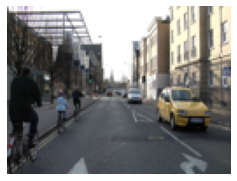

In [8]:
img = open_image(fnames[0])
img.show(figsize=(4,4))

In [9]:
# to input img file and output label file
tfm_lbl = lambda x: path_lbl/f"{x.stem}_P{x.suffix}"
tfm_lbl(fnames[0])

PosixPath('/root/.fastai/data/camvid_tiny/labels/0016E5_01920_P.png')

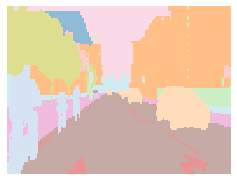

In [10]:
mask = open_mask(tfm_lbl(fnames[0]))
mask.show(figsize=(4,4))

// path, data and label match

now make databunch using this
there were 2 process.... but why did they this?

In [11]:
img.size, img.shape

(torch.Size([96, 128]), torch.Size([3, 96, 128]))

In [12]:
img.data

tensor([[[0.6980, 1.0000, 0.9451,  ..., 0.9961, 0.9922, 0.9804],
         [0.5294, 0.9961, 0.9529,  ..., 0.9922, 0.9843, 0.9882],
         [0.3647, 0.9020, 0.9059,  ..., 0.9922, 0.9882, 0.9725],
         ...,
         [0.3176, 0.0824, 0.1451,  ..., 0.2196, 0.2196, 0.2235],
         [0.2039, 0.0863, 0.1725,  ..., 0.2157, 0.1961, 0.2078],
         [0.2510, 0.1961, 0.0824,  ..., 0.2157, 0.2039, 0.2039]],

        [[0.6863, 0.9961, 0.9255,  ..., 0.9647, 0.9569, 0.9412],
         [0.5216, 0.9922, 0.9333,  ..., 0.9608, 0.9490, 0.9490],
         [0.3529, 0.8863, 0.8784,  ..., 0.9569, 0.9490, 0.9373],
         ...,
         [0.3216, 0.0824, 0.1490,  ..., 0.2471, 0.2392, 0.2392],
         [0.2118, 0.0863, 0.1686,  ..., 0.2353, 0.2235, 0.2353],
         [0.2510, 0.2000, 0.0863,  ..., 0.2353, 0.2314, 0.2314]],

        [[0.7059, 1.0000, 0.9647,  ..., 0.8196, 0.8196, 0.8039],
         [0.5412, 1.0000, 0.9686,  ..., 0.8196, 0.8118, 0.8118],
         [0.3569, 0.9020, 0.9255,  ..., 0.8196, 0.8157, 0.

In [0]:
src_size = np.array(img.size)

In [19]:
free= gpu_mem_get_free_no_cache()
if free>8400: bs=8
else:
    bs=4
print(f"Free memory:{free}MB free momory, you can use {bs} batch size")    

Free memory:16270MB free momory, you can use 8 batch size


Here we need to use tfm_y=True in the transform call because we need the same transforms to be applied to the target mask as were applied to the image. Side note: For further control over which transformations are used on the target, each transformation has a use_on_y parameter

Source: [fast.ai](https://docs.fast.ai/data_block.html)

- Option [split data: train/validation](https://docs.fast.ai/data_block.html#Step-2:-Split-the-data-between-the-training-and-the-validation-set)

In [15]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(tfm_lbl))

TypeError: ignored

Actually didn't render class parameter on purpose because it was somewhat not intuitive(or confusing) to give segment classes argument at function which matches images and masks.


And got typeError. Somewhere (maybe) `/usr/local/lib/python3.6/dist-packages/fastai/vision/data.py` check empty or not

In [0]:
classes = np.loadtxt(path/'codes.txt', dtype=str)

In [0]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct()
        .label_from_func(tfm_lbl, classes = classes))

## Quations
1. Why do we need size when do the transform?
2. This is method from `segmentation label list`, that means y should change depends on it. why that parameter needs?

In [0]:
data = src.transform(get_transforms(), size = src_size//2, tfm_y = True).databunch(bs=bs).normalize(imagenet_stats)

In [19]:
doc(get_transforms)

In [15]:
# defining accuracy for camvid
codetoid = {v:idx for idx, v in enumerate(classes)}
void_id = codetoid['Void']
void_id

30

In [0]:
def camvid_acc(predict, target):
    target = target.squeeze(1)
    mask = target != void_id
    return (predict.argmax(dim=1)[mask]==target[mask]).float().mean()
# means if target void, predict will become vacant tensor, and if not will print their own value

In [22]:
np.random.seed(0)
a = torch.tensor(np.random.rand(22,1)).argmax(dim=0); a
a[True]
a[False]

tensor([20])

tensor([[20]])

tensor([], size=(0, 1), dtype=torch.int64)

In [0]:
wd=1e-02
learn = unet_learner(data, models.resnet34, wd=wd, metrics=camvid_acc)

## Quastions
unet_learner - learn, and models.resnet 34? so that means pre-trained with resnet34 and will fine-tune with unet_learner??

## Quation
Why it does not removed...?

In [0]:
mask.data.shape
mask.data.squeeze_(1)
mask.data.shape

## Learn

In [18]:
learn.lr_find()

NameError: ignored

In [25]:
doc(learn.recorder.plot_lr)

In [26]:
doc(learn.recorder.plot)

In [0]:
learn.recorder.plot(suggestion=True)

In [22]:
lr = 3.31E-04
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,camvid_acc,time
0,3.562540,2.875916,0.213501,00:02
1,2.852880,1.748502,0.594681,00:00
2,2.342068,1.395652,0.609027,00:00
3,2.007456,1.184979,0.690197,00:00
4,1.794750,1.107142,0.707532,00:00
5,1.640689,1.030977,0.734819,00:00
6,1.503294,0.965888,0.768754,00:00
7,1.394088,0.915061,0.782429,00:00
8,1.297637,0.896237,0.786982,00:00
9,1.221316,0.890409,0.789179,00:00


In [0]:
learn.save('tmp-1')

In [0]:
gpu_mem_get_free_no_cache()

In [0]:
## don't run this.. you have to restart...
# learn.destroy()
# gpu_mem_get_free_no_cache()
# learn.load('tmp-1')

## Question
Save & Load가 뭘까? destroy를 쓰면 다시 불러올 때 no longer usable이라고 뜬다 ㅠㅠ
-> pth와 pickle의 차이는 뭘까?

In [0]:
doc(load_learner)

In [0]:
learn.unfreeze()

## Question

why this lr??

In [0]:
lrs = slice(lr/400, lr/4)

In [26]:
# lr = 1.91E-06
learn.fit_one_cycle(12, slice(lr, 3.31E-05), pct_start=0.8)

epoch,train_loss,valid_loss,camvid_acc,time
0,0.939345,0.884833,0.788744,00:01
1,0.928607,0.878709,0.790252,00:00
2,0.921385,0.869488,0.794353,00:01
3,0.918121,0.860181,0.797007,00:01
4,0.906267,0.860035,0.792772,00:00
5,0.902347,0.846095,0.795875,00:01
6,0.894921,0.831728,0.800781,00:00
7,0.885781,0.823409,0.802647,00:01
8,0.875647,0.818566,0.800699,00:00
9,0.863618,0.801180,0.808260,00:00


In [0]:
learn.save('tmp-2')

## Bigger

In [28]:
# reinitiate leaner # i forgot at the first divide src size...haha.. and i dont have to use small bs
learn.destroy()
data = src.transform(get_transforms(), size = src_size, tfm_y = True).databunch(bs=bs).normalize(imagenet_stats)

this Learner object self-destroyed - it still exists, but no longer usable


In [0]:
learn = unet_learner(data, models.resnet34, wd=wd, metrics=camvid_acc)
learn.load('tmp-2')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


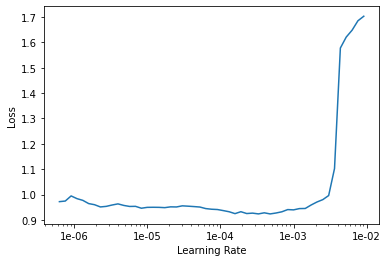

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 3e-03
learn.fit_one_cycle(8, lr, pct_start=0.8)

epoch,train_loss,valid_loss,camvid_acc,time
0,1.038488,0.896004,0.795183,00:02
1,0.956682,0.818034,0.809187,00:01
2,0.972324,0.959327,0.774311,00:01
3,0.957666,1.098027,0.725378,00:01
4,0.953265,0.915497,0.792103,00:01
5,0.953108,0.848536,0.800550,00:01
6,0.938447,0.746676,0.824421,00:01
7,0.890706,0.734459,0.820047,00:01


In [0]:
learn.save('bigger-1')
learn.load('bigger-1')

epoch,train_loss,valid_loss,camvid_acc,time
0,0.678964,0.720710,0.834964,00:01
1,0.660656,0.695742,0.833618,00:01
2,0.647027,0.675090,0.840018,00:01
3,0.644791,0.657200,0.835345,00:01
4,0.637825,0.687262,0.823947,00:01
5,0.630168,0.655579,0.840199,00:01
6,0.613188,0.654712,0.844893,00:01
7,0.596625,0.654658,0.845948,00:01
8,0.581589,0.647224,0.846836,00:01
9,0.570255,0.645893,0.847000,00:01


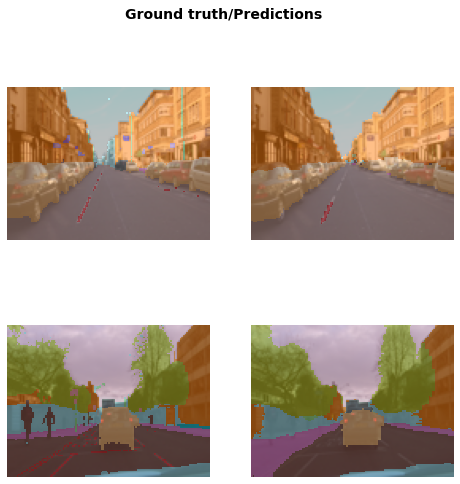

In [33]:
lrs = slice(1e-6,lr/10)
learn.unfreeze()
learn.fit_one_cycle(10, lrs)
learn.show_results(rows=2)